In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from data_preprocessing import preprocess

df1 = preprocess()

In [26]:

def correlation_matrix(patient_id, wave_option='power_beta'):
    # Filter data for the selected patient
    patient_data = df1[df1['id'] == patient_id]

    # Create an empty list to hold the power data for each region (channel)
    power_data = []

    # Loop through the regions (channels) and extract power data
    for region in patient_data['region'].unique():
        # Filter power data for the current region
        region_data = patient_data[patient_data['region'] == region]
        
        # Append the power data (list) for this region to the list
        power_data.append(region_data[wave_option].values[0])  # Assuming 'power' is a list

    # Convert the list of power data (regions x time points) into a DataFrame
    power_df = pd.DataFrame(power_data).transpose()  # 16 channels x 240 time points

    # Check for NaN values and fill or drop them
    if power_df.isnull().values.any():
        print(f"Warning: Missing values detected in power data for patient {patient_id}")
        power_df = power_df.fillna(0)  # Fill NaN with 0 (you can change this to another method)

    # Calculate the correlation matrix for the 16 regions (channels)
    corr_matrix = power_df.corr(method='pearson')  # Pearson correlation
    return corr_matrix


In [4]:

def average_correlation(patient_ids, wave_option='power_beta'):
    correlation_sums = None
    count = 0

    # Loop through each patient and calculate their correlation matrix
    for patient_id in patient_ids:
        corr_matrix = correlation_matrix(patient_id, wave_option)
        
        # Add the current correlation matrix to the cumulative sum
        if correlation_sums is None:
            correlation_sums = corr_matrix
        else:
            correlation_sums += corr_matrix
        
        count += 1

    # Calculate the average correlation matrix
    average_corr_matrix = correlation_sums / count
    return average_corr_matrix

In [5]:
healthy_patients = df1[df1['schizo'] == 0]['id'].unique().tolist()
schizo_patients = df1[df1['schizo'] == 1]['id'].unique().tolist()


#BETA

In [30]:
def plot_correlation_matrices(healthy_patients, schizo_patients, wave_option='power_beta'):
    # Calculate average correlation matrices for both healthy and schizophrenic patients
    avg_corr_healthy = average_correlation(healthy_patients, wave_option=wave_option)
    avg_corr_schizo = average_correlation(schizo_patients, wave_option=wave_option)
    corr_difference = avg_corr_healthy - avg_corr_schizo

    # Get the regions (they should be consistent across all patients)
    regions = avg_corr_healthy.columns.tolist()  # Get region names from the columns of the correlation matrix

    # Plot for healthy patients
    plt.figure(figsize=(10, 8))
    sns.heatmap(avg_corr_healthy, annot=True, cmap='coolwarm', fmt='.2f', xticklabels=regions, yticklabels=regions)
    plt.title(f"Average Correlation Matrix for Healthy Patients ({wave_option.capitalize()})")
    plt.xlabel('Regions (Channels)')
    plt.ylabel('Regions (Channels)')
    plt.show()

    # Plot for schizophrenic patients
    plt.figure(figsize=(10, 8))
    sns.heatmap(avg_corr_schizo, annot=True, cmap='coolwarm', fmt='.2f', xticklabels=regions, yticklabels=regions)
    plt.title(f"Average Correlation Matrix for Schizophrenic Patients ({wave_option.capitalize()})")
    plt.xlabel('Regions (Channels)')
    plt.ylabel('Regions (Channels)')
    plt.show()

    # Plot the correlation difference (healthy - schizo)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_difference, annot=True, cmap='coolwarm', fmt='.2f', xticklabels=regions, yticklabels=regions)
    plt.title('Correlation Difference (Healthy - Schizophrenic)')
    plt.xlabel('Regions (Channels)')
    plt.ylabel('Regions (Channels)')
    plt.show()

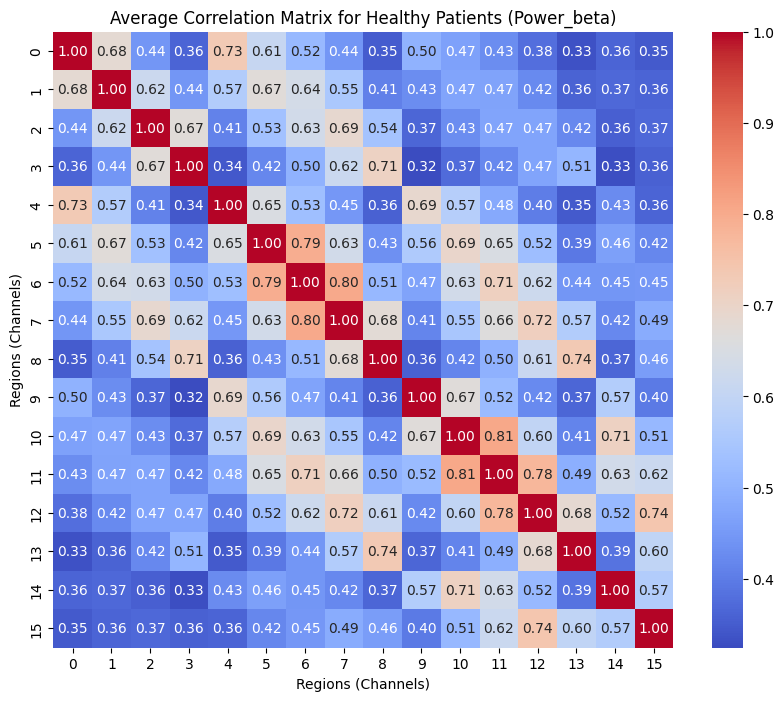

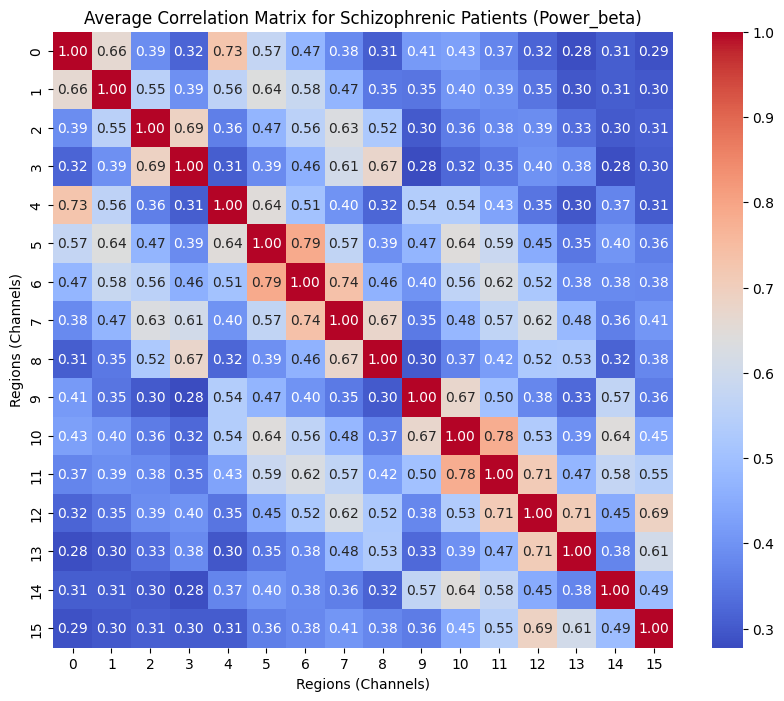

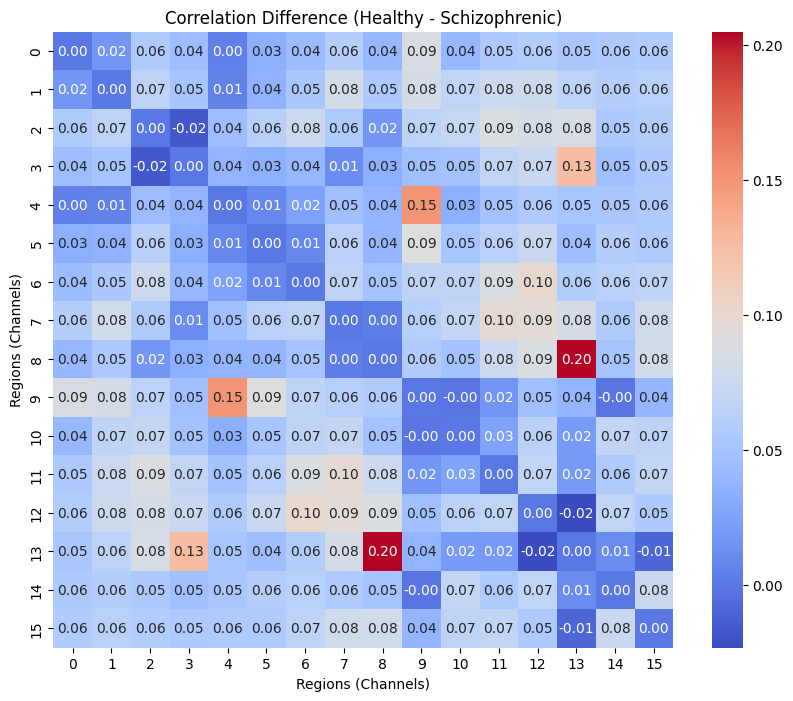

In [33]:
plot_correlation_matrices(healthy_patients, schizo_patients, wave_option='power_beta')

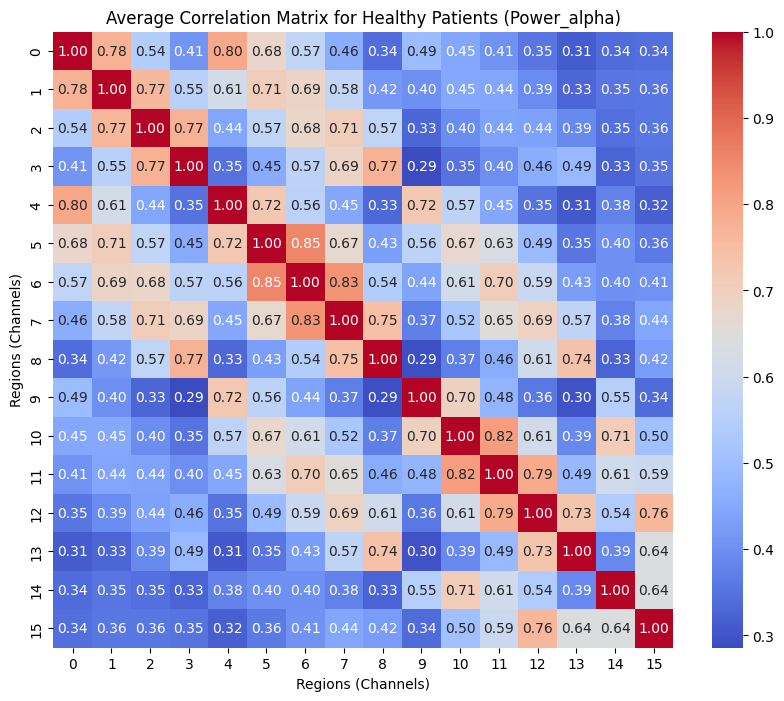

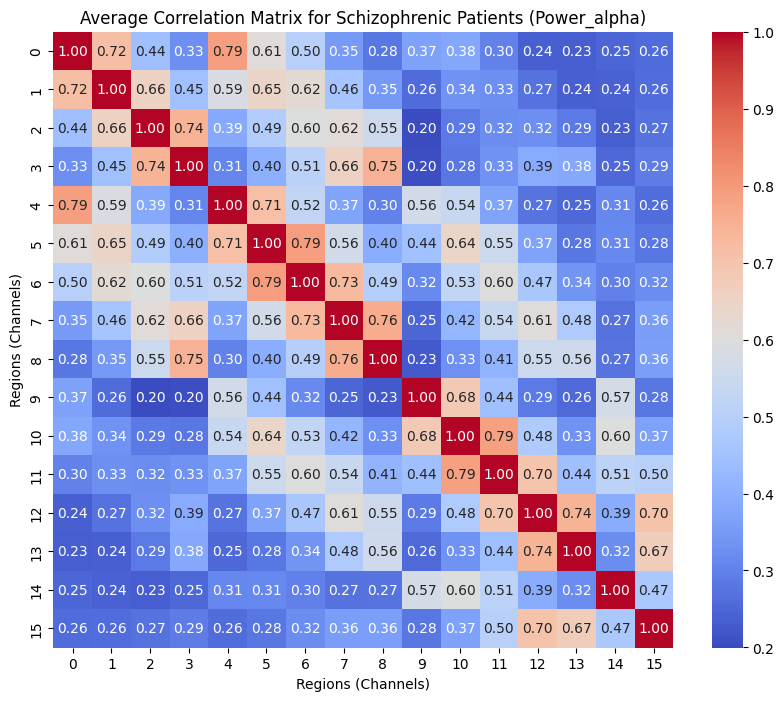

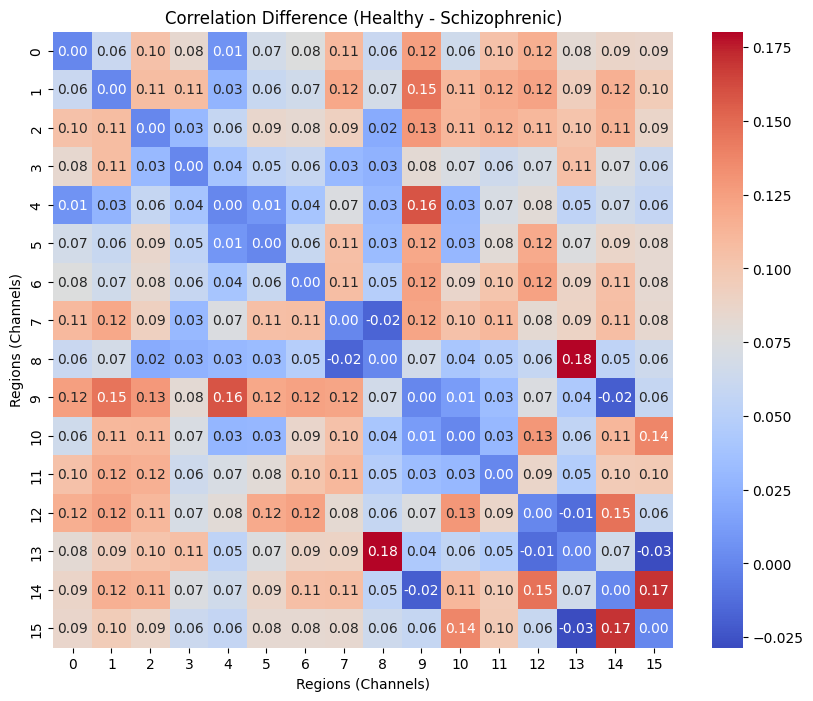

In [29]:
plot_correlation_matrices(healthy_patients, schizo_patients, wave_option='power_alpha')

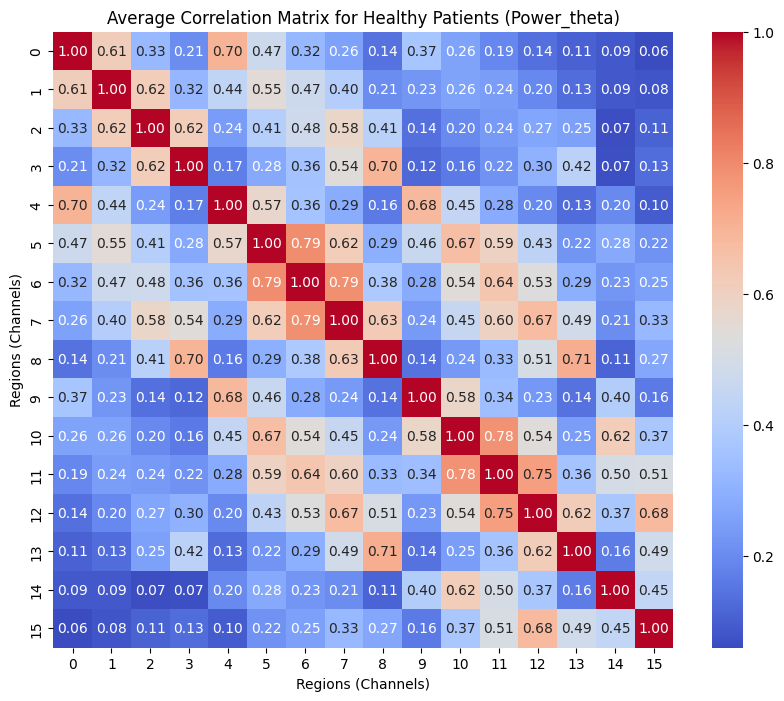

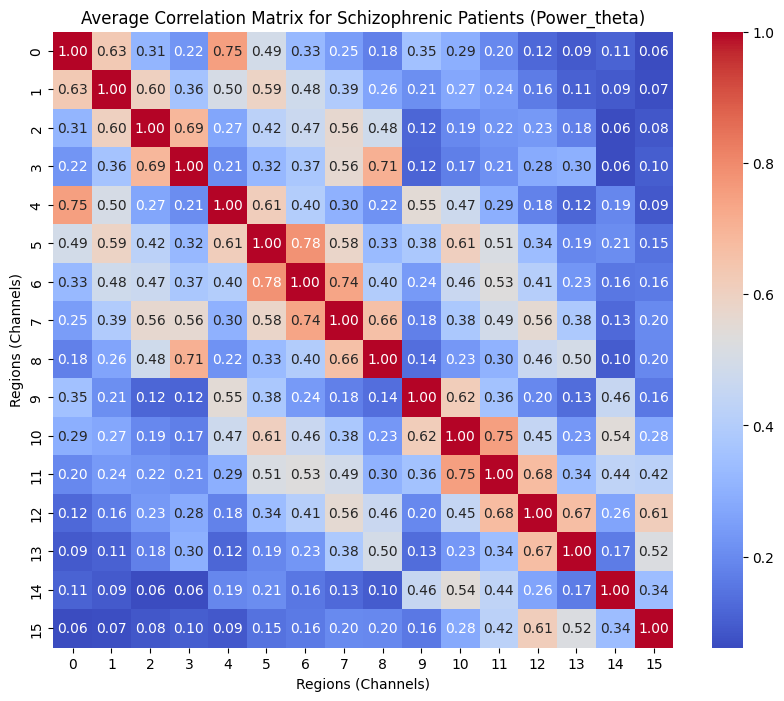

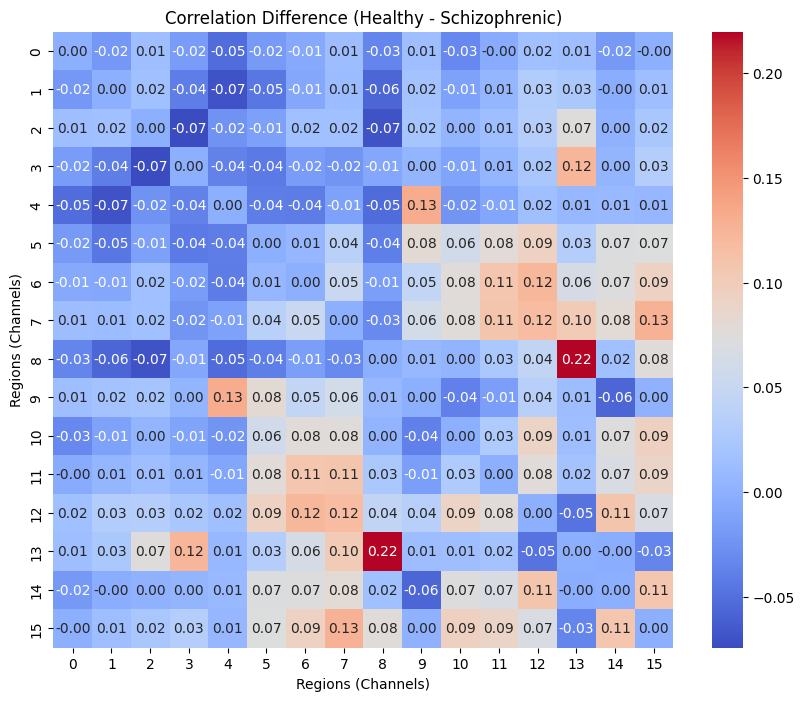

In [32]:
plot_correlation_matrices(healthy_patients, schizo_patients, wave_option='power_theta')